In [1000]:
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram, fcluster
from sklearn.ensemble import IsolationForest, RandomForestClassifier

%matplotlib inline

# 1. Data Processing

In [981]:
# Read data for PATH 5743
dir_path = "./data" # Put raw data and processed files here
#df = pd.read_csv(os.path.join(dir_path, "cleanedcombinedPath5743.csv"), low_memory=False)
df_1min = pd.read_csv(os.path.join(dir_path, "1minPath5743.csv"), low_memory=False)
df_15min = pd.read_csv(os.path.join(dir_path, "15minPath5743.csv"), low_memory=False)
df_30min = pd.read_csv(os.path.join(dir_path, "30minPath5743.csv"), low_memory=False)

In [371]:
#df.info()
df_1min.head()

,Time,Time(EDT (UTC - 4 hr)),Wheel Speed(mph),Speed(mph),BC Pres(psi),BP Pres(psi),Reversor Pos,Altitude(ft),BC1 Pres(psi),BC2 Pres(psi),...,Master Controller On Local,Master Controller On Train,Third Rail Power Inverter Operational,Third Rail Power LVPS Operational,Latitude(deg),Longitude(deg),Location,Mile Post Number,Subdivision,Rail Road
0,2024-03-01 00:13:00,3/1/2024 12:13.09.0 AM,0.4,0.7,0.0,138.0,Forward,220.0,0.0,0.0,...,On,On,On,Off,40.74062,-74.14627,"Harrison, NJ",NaN,NaN,NaN
1,2024-03-01 00:14:00,3/1/2024 12:14.00.0 AM,3.4,3.5,0.0,139.0,Forward,40.0,0.0,0.0,...,On,On,On,On,40.74085,-74.14585,"Harrison, NJ",NaN,NaN,NaN
2,2024-03-01 00:15:00,3/1/2024 12:15.00.0 AM,0.0,0.0,29.0,146.0,Reverse,30.0,29.0,29.0,...,On,On,On,On,40.74102,-74.14798,"Harrison, NJ",NaN,NaN,NaN
3,2024-03-01 00:16:00,3/1/2024 12:16.00.0 AM,0.0,0.0,29.0,145.0,Reverse,30.0,29.0,29.0,...,On,On,On,On,40.74102,-74.14798,"Harrison, NJ",NaN,NaN,NaN
4,2024-03-01 00:17:00,3/1/2024 12:17.00.0 AM,0.0,8.9,0.0,137.0,Reverse,40.0,0.0,0.0,...,On,On,On,On,40.74029,-74.14567,"Harrison, NJ",NaN,NaN,NaN


In [372]:
# Drop columns: 
# "Time(EDT (UTC - 4 hr))"" is a duplicate of "Time" 
# "Distance Traveled(ft)" has the same values everywhere

#df.drop(columns=["Time(EDT (UTC - 4 hr))", "Distance Traveled(ft)"], inplace=True)
df_1min.drop(columns=["Time(EDT (UTC - 4 hr))", "Distance Traveled(ft)"], inplace=True)
df_15min.drop(columns=["Time(EDT (UTC - 4 hr))", "Distance Traveled(ft)"], inplace=True)
df_30min.drop(columns=["Time(EDT (UTC - 4 hr))", "Distance Traveled(ft)"], inplace=True)

In [373]:
numeric_cols = df.select_dtypes(include=['float64']).columns
time_cols = ['Time']
categorical_cols = [c for c in df.select_dtypes(include=['object']).columns if c not in time_cols]

In [718]:
def featurize_data(df, time_cols, numeric_cols, categorical_cols, drop_nan_dummy=True):
    # Some telemetry is off when "Wheel Speed(mph)" is nan
    # Option 1: drop "Wheel Speed(mph)" is nan
    # Option 2: flag it as missing --> going with option 2 here
    
    df_out = df.copy(deep=True)
    # Handle time columns
    for c in time_cols:
        if c in df_out.columns:
            df_out[c] = pd.to_datetime(df_out[c], errors='coerce')
            df_out[f"{c}_IsWeekend"] = df_out[c].dt.weekday >= 5
            df_out[f"{c}_Hour"] = df_out[c].dt.hour
            df_out[f"{c}_Weekday"] = df_out[c].dt.weekday
    
    # Fill in numeric nan numeric columns
    df_out["Wheel Speed(mph)_nan"] = df_out["Wheel Speed(mph)"].isna()*1
    df_out[numeric_cols] = df_out[numeric_cols].fillna(df_out[numeric_cols].mean())
    
    # Encode categorical variables as dummies
    if drop_nan_dummy:
        df_out = pd.get_dummies(df_out, columns=categorical_cols, drop_first=False, dummy_na=True)
        df_out = df_out.drop(columns=[f"{c}_nan" for c in categorical_cols])
    else:
        df_out = pd.get_dummies(df_out, columns=categorical_cols, drop_first=True, dummy_na=True)
    
    return df_out

In [719]:
#df = featurize_data(df, time_cols, numeric_cols, categorical_cols)
df_1min_feat = featurize_data(df_1min, time_cols, numeric_cols, categorical_cols, drop_nan_dummy=False)
df_15min_feat = featurize_data(df_15min, time_cols, numeric_cols, categorical_cols, drop_nan_dummy=False)

# 2. Data Modeling: Correlation Analysis 

In [313]:
# Need to drop 'Wheel Speed(mph)_nan' when using drop_nan_dummy=True
#corr_matrix = df_1min.drop(columns=["Wheel Speed(mph)_nan"]).corr()
corr_matrix = df_1min_feat.corr()

C:\Users\anton\AppData\Local\Temp\ipykernel_15708\2174659769.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_1min.corr()


In [314]:
# Perform hierarchical clustering
distance_matrix = 1 - corr_matrix.abs() 
linkage_matrix = linkage(distance_matrix, method='ward')
cluster_order = leaves_list(linkage_matrix)
clustered_corr = corr_matrix.iloc[cluster_order, cluster_order]

C:\Users\anton\AppData\Local\Temp\ipykernel_15708\1289934931.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


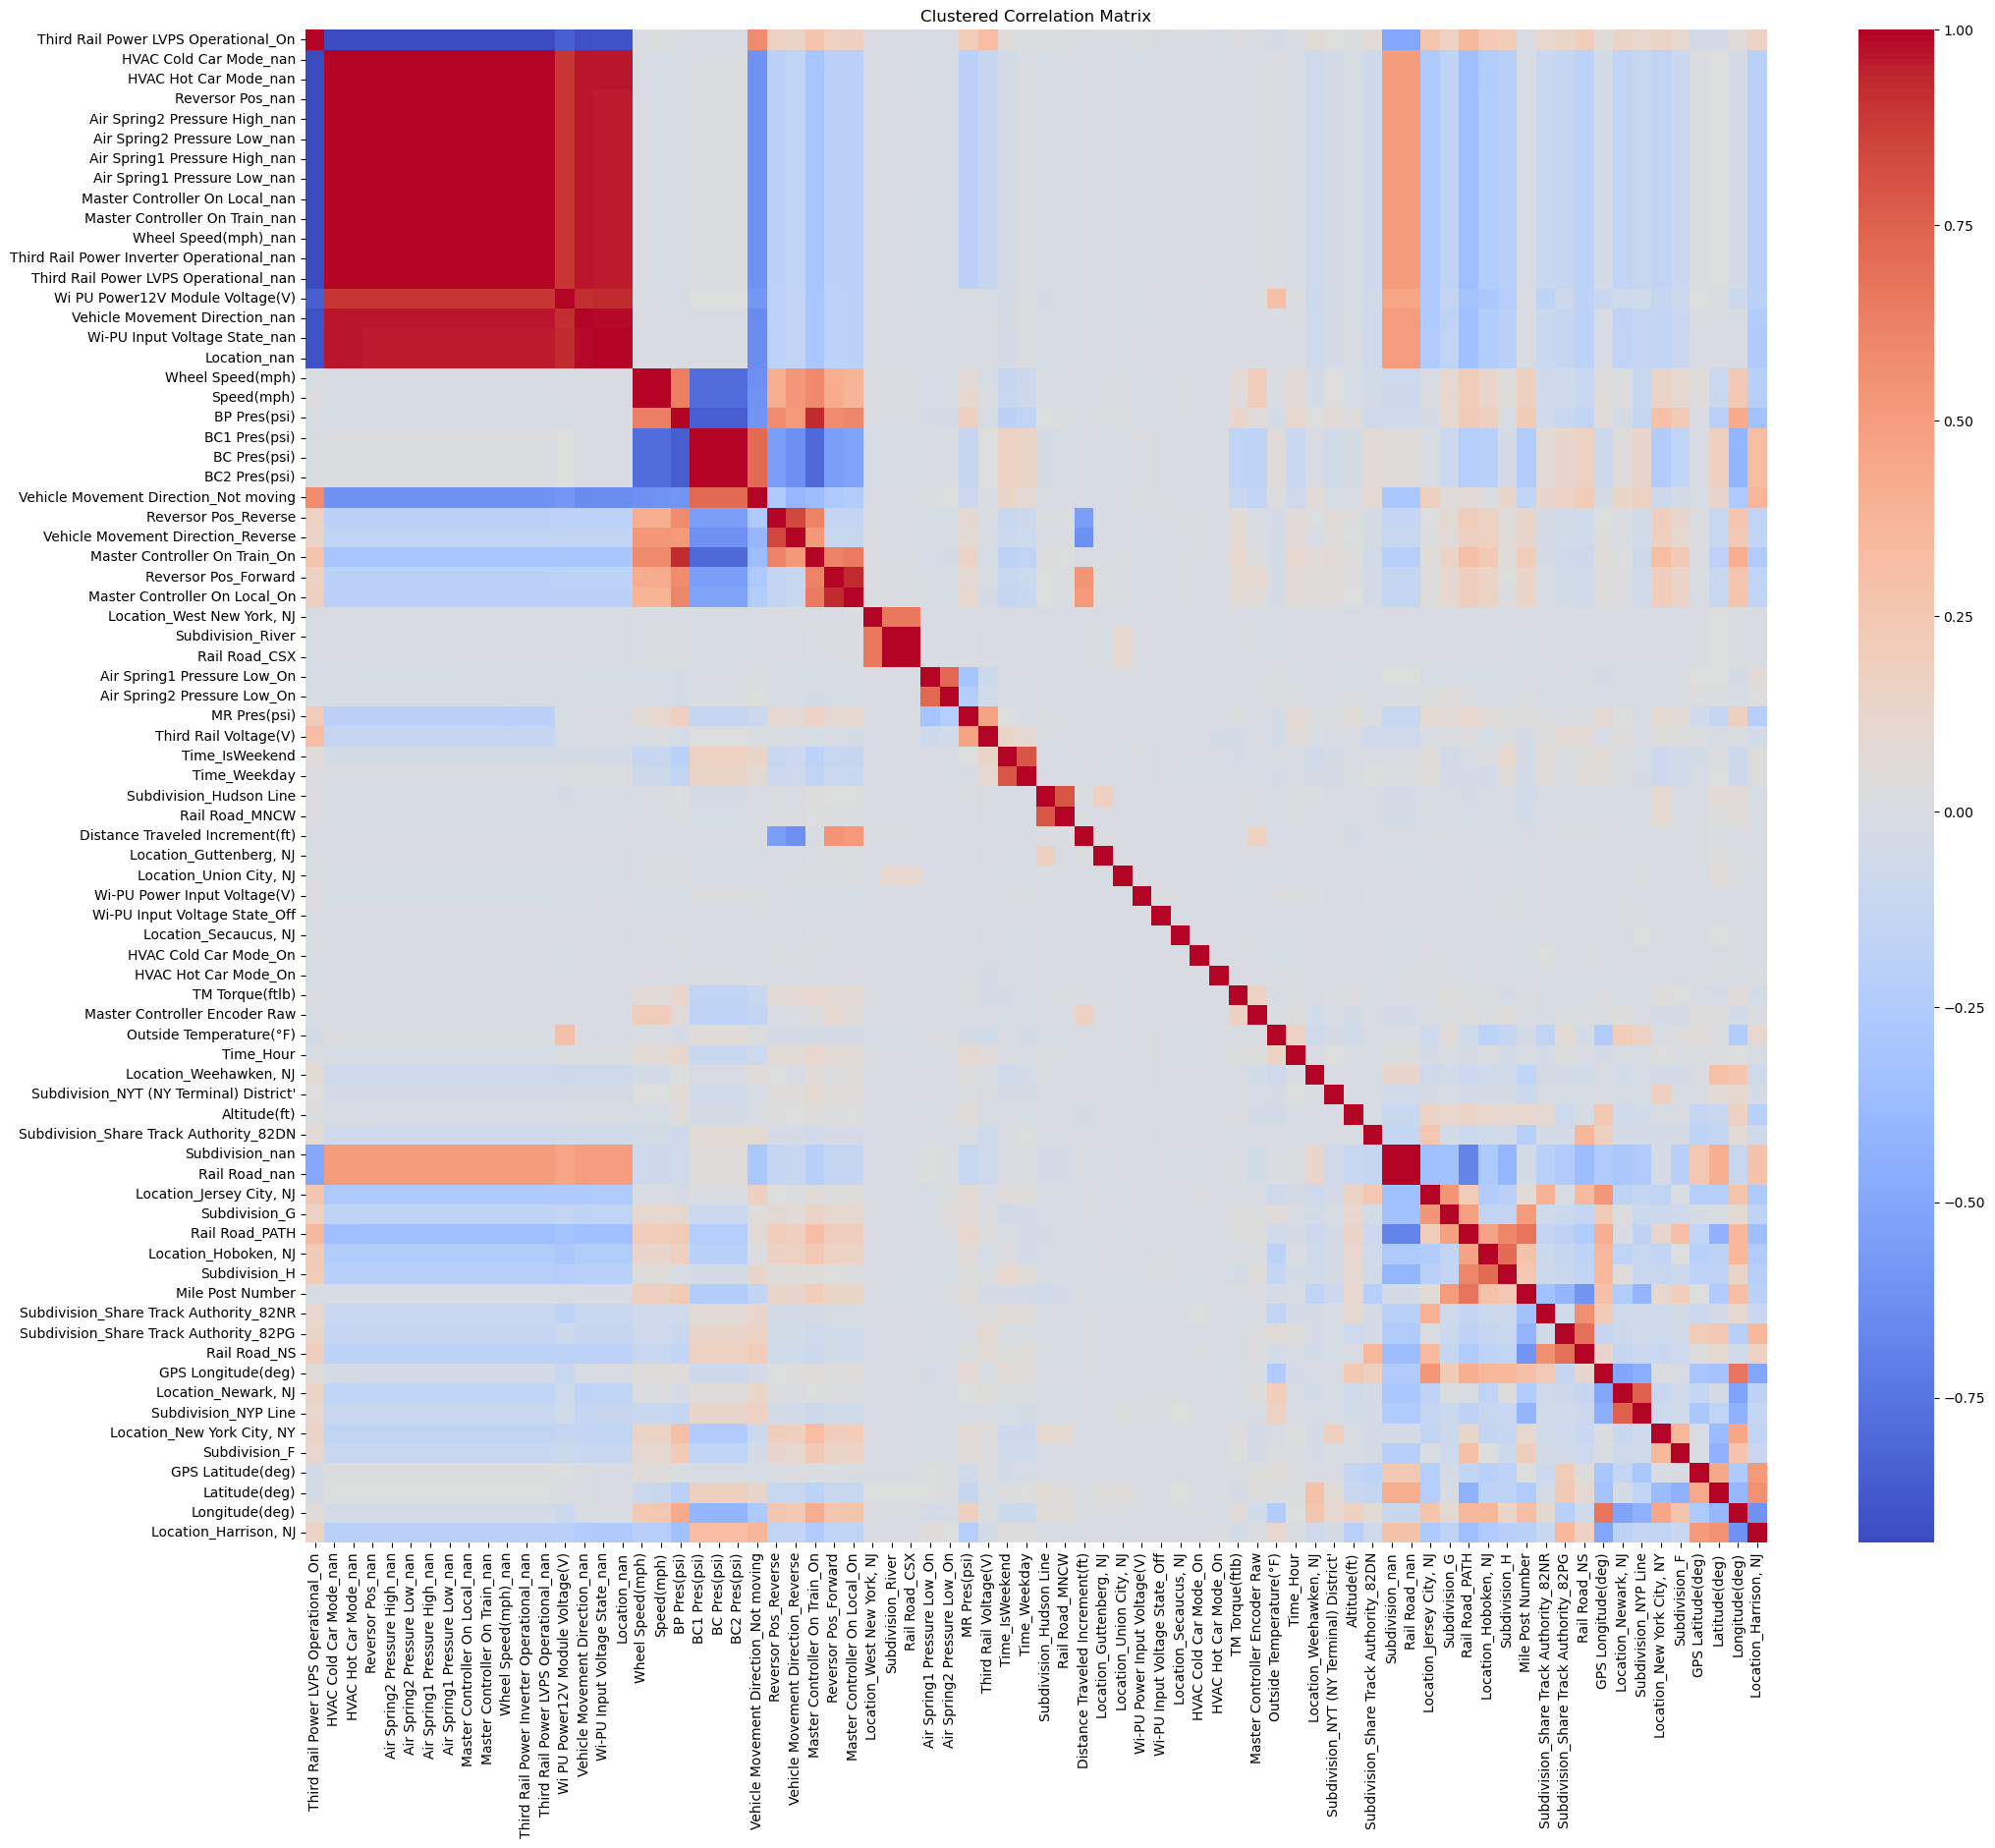

In [316]:
plt.figure(figsize=(24, 20))
sns.heatmap(clustered_corr, annot=False, cmap="coolwarm", cbar=True)
plt.title("Clustered Correlation Matrix")
plt.savefig("./figures/Clustered_Correlation_Matrix_drop_first_dummy.png", bbox_inches="tight", dpi=300)
#plt.savefig("./figures/Clustered_Correlation_Matrix_drop_nan_dummy.png", bbox_inches="tight", dpi=300)
plt.show()

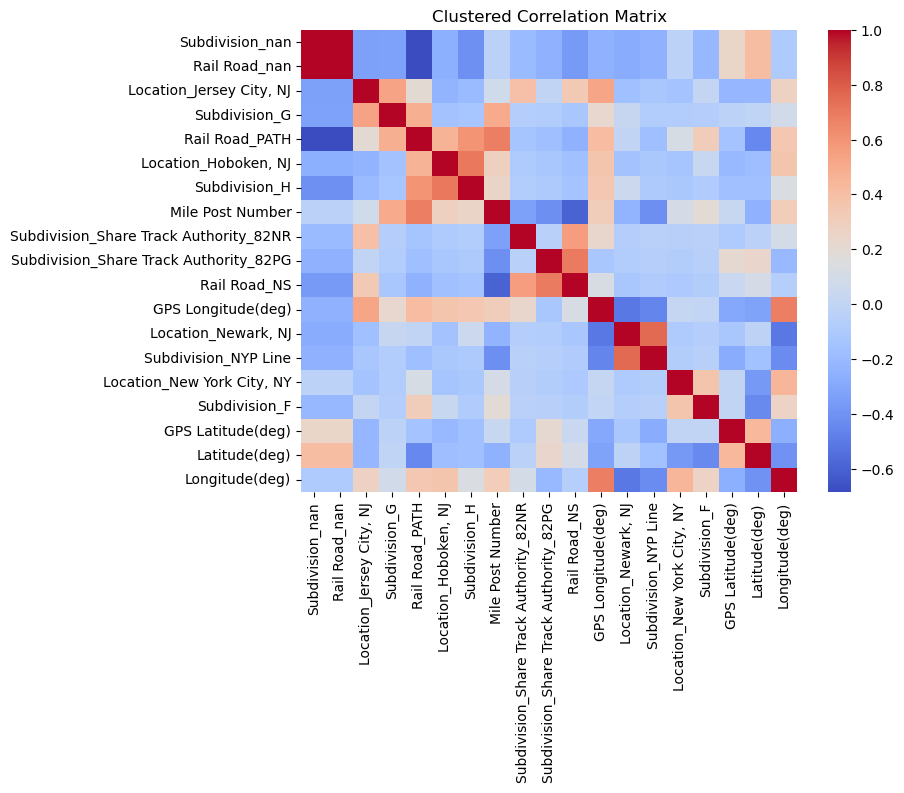

In [324]:
# Clusters for "drop_nan_dummy": np.arange(17), np.arange(17, 32), np.arange(51,75)
# Clusters for "drop_first_dummy": np.arange(17), np.arange(17, 29), np.arange(56,75)
plt.figure(figsize=(8, 6))
sns.heatmap(clustered_corr.iloc[np.arange(56, 75), np.arange(56, 75)], annot=False, cmap="coolwarm", cbar=True)
plt.title("Clustered Correlation Matrix")
plt.savefig("./figures/Clustered_Correlation_Matrix_drop_first_dummy_cluster_3.png", bbox_inches="tight", dpi=300)
#plt.savefig("./figures/Clustered_Correlation_Matrix_drop_nan_dummy_cluster_3.png", bbox_inches="tight", dpi=300)
plt.show()

In [436]:
stations = {"Newark": [40.7347, -74.1641], 
            "Harrison": [40.7394, -74.1559], 
            "JSQ": [40.73282, -74.0627], 
            "Grove St": [40.7218, -74.0447],
            "Exchange": [40.71745, -74.03229],
            "WTC": [40.7115, -74.0114]
           }

In [823]:
def plot_daily_trajectory(month, day):
    df_filter = (pd.to_datetime(df_1min["Time"], errors='coerce').dt.month==month) & \
                (pd.to_datetime(df_1min["Time"], errors='coerce').dt.day==day)
    plt.scatter(df_1min["Longitude(deg)"][df_filter], 
            df_1min["Latitude(deg)"][df_filter], label="Lat/Lon PATH 5743")
    for station, (lat, lon) in stations.items():
        plt.scatter([lon], [lat], label=station, edgecolors='black')
    plt.legend()
    plt.xlim(-74.3, -73.8)
    plt.ylim(40.6, 40.9)
    plt.show()

In [982]:
def annimate_daily_trajectory(month, day, save=True):
    df_filter = (pd.to_datetime(df_1min["Time"], errors='coerce').dt.month==month) & \
            (pd.to_datetime(df_1min["Time"], errors='coerce').dt.day==day)

    # Extract longitude and latitude
    times = df_1min["Time"][df_filter].values
    times_dt = pd.to_datetime(df_1min["Time"], errors='coerce')[df_filter]
    longitudes = df_1min["Longitude(deg)"][df_filter].values
    latitudes = df_1min["Latitude(deg)"][df_filter].values

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 4.578))
    img1 = mpimg.imread('./figures/Stations.jpg')
    img2 = mpimg.imread('./figures/Stations_weekends.jpg')

    img1_display = ax.imshow(img1, extent=[-74.2034, -73.9440, 40.6868, 40.7692], aspect='auto')
    img2_display = ax.imshow(img2, extent=[-74.2034, -73.9440, 40.6868, 40.7692], aspect='auto')

    # Create the plot

    # Plot labels
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")
    ax.set_title("PATH 5743 Movement")

    # Initialize a single point
    dot = ax.scatter([], [], s=50, zorder=10, edgecolor='black', marker="s", label="PATH 5743")  # Blue PATH
    ax.legend()
    hist_len = 1
    alpha = np.arange(hist_len+1)/hist_len

    # Function to initialize the animation
    def init():
        img1_display.set_alpha(0)
        img2_display.set_alpha(1)
        return dot, img1_display, img2_display

    # Function to update the animation at each time step
    state = {'night': True, 'weekend': (times_dt.dt.weekday.values[1] >= 5)}
    def update(frame):
        if not state['weekend']:
            if state['night'] and times_dt.dt.hour.values[frame] >= 6:
                img1_display.set_alpha(1)
                img2_display.set_alpha(0)
                state['night'] = False
            if not state['night'] and times_dt.dt.hour.values[frame] >= 23:
                img1_display.set_alpha(0)
                img2_display.set_alpha(1)
                state['night'] = True
        if frame >= hist_len:
            dot.set_offsets(
                np.hstack((longitudes[frame-hist_len:frame+1].reshape(-1, 1), 
                           latitudes[frame-hist_len:frame+1].reshape(-1, 1))))
            dot.set_alpha(alpha=alpha)
        else:
            dot.set_offsets(
                np.hstack((longitudes[:frame+1].reshape(-1, 1), 
                           latitudes[:frame+1].reshape(-1, 1))))
        ax.set_title(f"PATH 5743 Movement: {times[frame]}")
        return dot,

    # Create the animation
    num_frames = len(longitudes)  # Total number of frames
    animation = FuncAnimation(
        fig, update, frames=num_frames, init_func=init, blit=True, interval=20, repeat=False
    )
    
    if save:
        # Save the animation as a video or GIF
        animation.save(f'figures/PATH_movement_month_{month}_day_{day}.gif', writer='pillow', fps=20, dpi=100)
        
    return animation
    #plt.show()

<IPython.core.display.Javascript object>


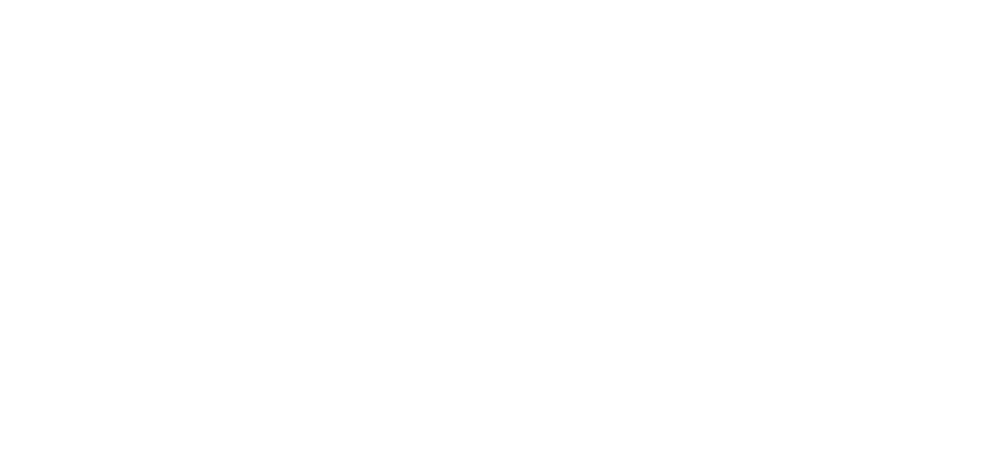

In [986]:
%matplotlib notebook

month = 5
day = 28
animation = annimate_daily_trajectory(month, day, save=True)
plt.show()

# 3. Data Modeling: Outlier Detection 

We will use the [Isolation Forest](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.IsolationForest.html) algorithm to detect outlier time periods or outlier days. We will contrast these with the "inliers", i.e. the data points we are most likely to see in the distribution.

## 3.1 Outlier detection on the minute scale

Directly run the ``IsolationForest`` on the 1 minute or 15 minute scale.

In [870]:
%matplotlib notebook

In [912]:
X = df_15min_feat.drop(columns=["Time", "GPS Longitude(deg)", "GPS Latitude(deg)"]).values

In [927]:
clf = IsolationForest(random_state=42, contamination=0.05).fit(X)  #Set contamination to determine outlier fraction
preds = clf.predict(X)
scores = clf.decision_function(X)
print(preds[preds==-1].sum())

-810


In [940]:
# Outlier times
df_15min_feat["Time"][np.argsort(scores)].head(20)

3264    2024-04-04 00:00:00
6438    2024-05-07 01:30:00
16130   2024-08-16 00:30:00
3269    2024-04-04 01:15:00
1381    2024-03-15 09:15:00
3268    2024-04-04 01:00:00
11941   2024-07-03 09:15:00
11939   2024-07-03 08:45:00
11347   2024-06-27 04:45:00
1369    2024-03-15 06:15:00
11339   2024-06-27 02:45:00
1380    2024-03-15 09:00:00
1367    2024-03-15 05:45:00
1368    2024-03-15 06:00:00
1362    2024-03-15 04:30:00
1363    2024-03-15 04:45:00
5428    2024-04-26 13:00:00
1365    2024-03-15 05:15:00
10581   2024-06-19 05:15:00
16131   2024-08-16 00:45:00
Name: Time, dtype: datetime64[ns]

In [929]:
# Outlier days
pd.to_datetime(df_15min_feat["Time"][preds==-1]).dt.strftime('%Y-%m-%d').unique()

array(['2024-03-01', '2024-03-06', '2024-03-07', '2024-03-08',
       '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12',
       '2024-03-15', '2024-03-16', '2024-03-17', '2024-03-18',
       '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22',
       '2024-03-23', '2024-03-25', '2024-03-27', '2024-03-28',
       '2024-03-31', '2024-04-02', '2024-04-03', '2024-04-04',
       '2024-04-05', '2024-04-07', '2024-04-08', '2024-04-09',
       '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
       '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-20',
       '2024-04-21', '2024-04-22', '2024-04-23', '2024-04-24',
       '2024-04-25', '2024-04-26', '2024-04-29', '2024-05-03',
       '2024-05-05', '2024-05-06', '2024-05-07', '2024-05-11',
       '2024-05-12', '2024-05-13', '2024-05-18', '2024-05-19',
       '2024-05-20', '2024-05-22', '2024-05-23', '2024-05-24',
       '2024-05-28', '2024-05-29', '2024-06-01', '2024-06-02',
       '2024-06-03', '2024-06-05', '2024-06-06', '2024-

In [934]:
# Outlier times
df_15min_feat["Time"][preds==-1]

0       2024-03-01 00:00:00
6       2024-03-01 01:30:00
24      2024-03-01 06:00:00
33      2024-03-01 08:15:00
518     2024-03-06 09:30:00
                ...        
16152   2024-08-16 06:00:00
16153   2024-08-16 06:15:00
16154   2024-08-16 06:30:00
16155   2024-08-16 06:45:00
16156   2024-08-16 07:00:00
Name: Time, Length: 810, dtype: datetime64[ns]

In [935]:
# Inliers
df_15min_feat["Time"][np.argsort(scores)[::-1]]

1318    2024-03-14 17:30:00
1221    2024-03-13 17:15:00
15301   2024-08-07 09:15:00
1223    2024-03-13 17:45:00
1320    2024-03-14 18:00:00
                ...        
1381    2024-03-15 09:15:00
3269    2024-04-04 01:15:00
16130   2024-08-16 00:30:00
6438    2024-05-07 01:30:00
3264    2024-04-04 00:00:00
Name: Time, Length: 16417, dtype: datetime64[ns]

In [936]:
df_15min_feat["Time"][np.argsort(scores)[::-1]].dt.strftime('%Y-%m-%d').unique()

array(['2024-03-14', '2024-03-13', '2024-08-07', '2024-06-06',
       '2024-03-15', '2024-06-27', '2024-06-28', '2024-07-26',
       '2024-05-29', '2024-05-23', '2024-07-02', '2024-05-24',
       '2024-06-26', '2024-06-04', '2024-03-26', '2024-05-01',
       '2024-05-27', '2024-05-22', '2024-05-03', '2024-06-14',
       '2024-04-25', '2024-06-17', '2024-03-27', '2024-05-06',
       '2024-05-04', '2024-08-01', '2024-06-18', '2024-08-13',
       '2024-05-28', '2024-07-11', '2024-03-29', '2024-06-10',
       '2024-08-05', '2024-07-03', '2024-03-28', '2024-04-12',
       '2024-05-02', '2024-03-07', '2024-08-08', '2024-08-02',
       '2024-07-29', '2024-04-06', '2024-05-26', '2024-05-21',
       '2024-03-20', '2024-04-03', '2024-03-06', '2024-05-25',
       '2024-06-05', '2024-04-24', '2024-06-21', '2024-06-16',
       '2024-03-12', '2024-06-12', '2024-06-29', '2024-05-05',
       '2024-04-01', '2024-07-23', '2024-03-04', '2024-04-07',
       '2024-06-15', '2024-04-05', '2024-03-01', '2024-

## 3.2 Outlier detection on the daily scale

We attempt two techniques:

1. Manual feature engineering for daily features
2. Variational auto-encoder for daily features

In [955]:
def featurize_day(df, date_col, metrics, freq='1D'):
    """
    Featurize a day's worth of data into daily-level features.
    
    Args:
        df (pd.DataFrame): Minute-by-minute data for the train.
        date_col (str): Name of the column containing timestamps.
        metrics (list of str): List of metric columns to featurize.
        freq (str): Frequency to resample ('1D' for daily).
    
    Returns:
        pd.DataFrame: DataFrame with daily features.
    """
    # Ensure datetime format
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    
    # Group by day and compute features
    # ['mean', 'std', 'min', 'max', 'sum']
    daily_features = df.resample(freq).agg({
        metric: ['mean', 'std'] for metric in metrics
    })
    
    # Flatten MultiIndex columns
    daily_features.columns = ['_'.join(col) for col in daily_features.columns]
    
    # Add additional features
    daily_features['IsWeekday'] = daily_features.index.weekday.map(lambda x: 0 if x >= 5 else 1)
    
    return daily_features.reset_index()

In [973]:
# Example usage
metrics = ['Speed(mph)', 'BC Pres(psi)', 'BP Pres(psi)', 
           'Distance Traveled Increment(ft)', 'Outside Temperature(°F)',
           'Third Rail Voltage(V)', 'TM Torque(ftlb)',
           'Wi PU Power12V Module Voltage(V)', 'Wi-PU Power Input Voltage(V)',
           'Master Controller Encoder Raw', 'Latitude(deg)', 'Longitude(deg)',
           'Mile Post Number', 'Wheel Speed(mph)_nan', 'Reversor Pos_Forward', 'Reversor Pos_Reverse',
           'Reversor Pos_nan', 'Vehicle Movement Direction_Not moving',
           'Vehicle Movement Direction_Reverse', 'Vehicle Movement Direction_nan',
           'Wi-PU Input Voltage State_Off', 'Wi-PU Input Voltage State_nan',
           'Air Spring1 Pressure High_nan', 'Air Spring1 Pressure Low_On',
           'Air Spring1 Pressure Low_nan', 'HVAC Cold Car Mode_On', 'HVAC Cold Car Mode_nan',
           'HVAC Hot Car Mode_On', 'HVAC Hot Car Mode_nan',
           'Master Controller On Local_On', 'Master Controller On Local_nan',
           'Master Controller On Train_On', 'Master Controller On Train_nan',
           'Third Rail Power Inverter Operational_nan',
           'Third Rail Power LVPS Operational_On',
           'Third Rail Power LVPS Operational_nan', 'Subdivision_Share Track Authority_82NR',
           'Subdivision_Share Track Authority_82PG', 'Subdivision_nan',
           'Rail Road_CSX', 'Rail Road_MNCW', 'Rail Road_NS', 'Rail Road_PATH',
           'Rail Road_nan']
daily_features = featurize_day(df_1min_feat, date_col='Time', metrics=metrics)
daily_features.fillna(value=0, inplace=True)

In [974]:
X = daily_features.drop(columns=["Time"]).values

In [975]:
clf = IsolationForest(random_state=42, contamination=0.05).fit(X)  #Set contamination to determine outlier fraction
preds = clf.predict(X)
scores = clf.decision_function(X)
print(preds[preds==-1].sum())

-9


In [978]:
# Most "outlier days" days
daily_features["Time"][np.argsort(scores)][preds[np.argsort(scores)]==-1]

127   2024-07-06
14    2024-03-15
110   2024-06-19
124   2024-07-03
118   2024-06-27
47    2024-04-17
67    2024-05-07
168   2024-08-16
52    2024-04-22
Name: Time, dtype: datetime64[ns]

In [979]:
# Most "inlier" days
daily_features["Time"][np.argsort(scores)[::-1]][preds[np.argsort(scores)[::-1]]==1]

89    2024-05-29
82    2024-05-22
88    2024-05-28
17    2024-03-18
28    2024-03-29
         ...    
46    2024-04-16
131   2024-07-10
34    2024-04-04
51    2024-04-21
92    2024-06-01
Name: Time, Length: 163, dtype: datetime64[ns]

Find important features for anomaly detection using a [RandomForestClassifier](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [997]:
y = (preds==-1) * 1
rf = RandomForestClassifier(max_depth=5)
rf.fit(X, y)

RandomForestClassifier(max_depth=5)

In [1034]:
no_feats = 10
top_feats = daily_features.drop(columns=["Time"]).columns[np.argsort(rf.feature_importances_)[::-1]][:no_feats]

In [1035]:
print(top_feats)

Index(['Wi-PU Power Input Voltage(V)_mean', 'Wi-PU Power Input Voltage(V)_std',
       'Air Spring1 Pressure Low_On_std', 'Third Rail Voltage(V)_mean',
       'Air Spring1 Pressure Low_On_mean',
       'Vehicle Movement Direction_nan_std', 'Third Rail Voltage(V)_std',
       'Wheel Speed(mph)_nan_std', 'Wi-PU Input Voltage State_nan_std',
       'Air Spring1 Pressure Low_nan_std'],
      dtype='object')


In [1036]:
shap_values[1][:, np.argsort(rf.feature_importances_)[::-1][:no_feats]].shape

(172, 10)

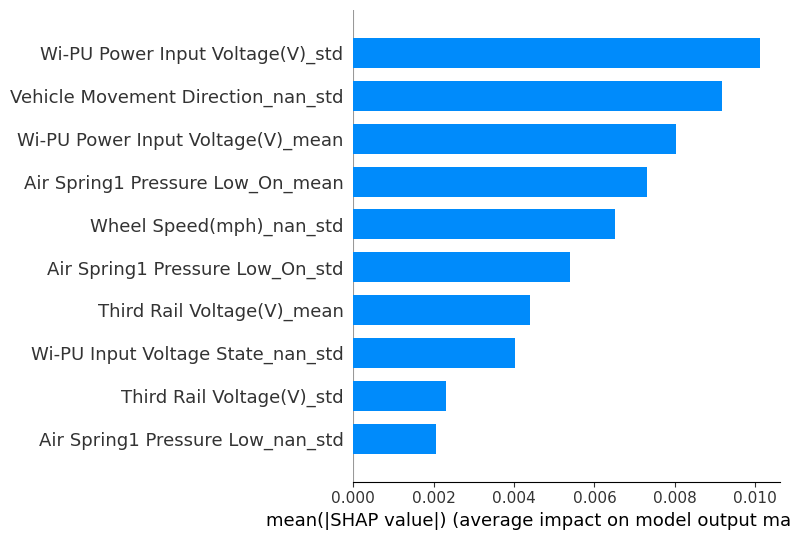

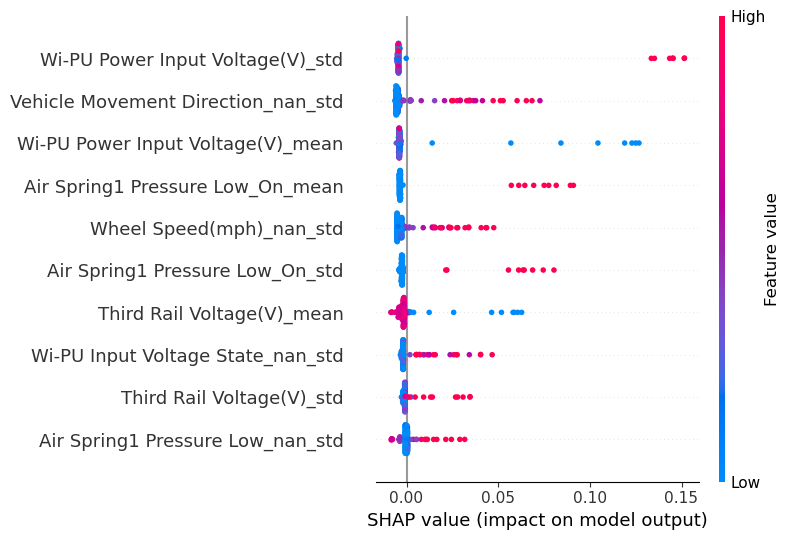

In [1041]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf, X)

# Compute SHAP values
shap_values = explainer.shap_values(X)

# Summary plot (global feature importance)
shap.summary_plot(shap_values[1][:, np.argsort(rf.feature_importances_)[::-1][:no_feats]], daily_features.drop(columns=["Time"])[top_feats], 
                  plot_type="bar", show=False, feature_names=top_feats)
plt.savefig("./figures/Outlier_analysis_important_features.png", bbox_inches="tight", dpi=200)
plt.show()

# Optional: Detailed summary plot with feature distribution
#shap.summary_plot(shap_values[1], X, show=True, feature_names=daily_features.drop(columns=["Time"]).columns, max_display=10)
shap.summary_plot(shap_values[1][:, np.argsort(rf.feature_importances_)[::-1][:no_feats]], daily_features.drop(columns=["Time"])[top_feats], 
                  show=False, feature_names=top_feats)
plt.savefig("./figures/Outlier_analysis_shap_plot.png", bbox_inches="tight", dpi=200)
plt.show()